In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 25)

### **Latar Belakang**

[TransJakarta, sebagai sistem _Bus Rapid Transit_ (BRT) pertama di Indonesia, diluncurkan pada tahun 2004](https://transjakarta.co.id/tentang/sejarah) dengan tujuan menyediakan transportasi massal yang efisien, terjangkau, dan ramah lingkungan. Sistem ini dirancang untuk mengurangi ketergantungan masyarakat pada kendaraan pribadi dan meningkatkan mobilitas perkotaan, namun masih menghadapi berbagai tantangan operasional yang mempengaruhi kualitas layanan. 

Beberapa masalah utama yang dihadapi adalah: [durasi perjalanan, kepadatan penumpang pada jam sibuk, kondisi infrastruktur yang memerlukan pemeliharaan, serta integrasi dengan moda transportasi lain](https://purejournal.ub.ac.id/index.php/pure/article/view/328/260). Tantangan-tantangan ini mempengaruhi kepuasan pengguna dan efektivitas keseluruhan sistem transportasi publik di Jakarta.

### **Pernyataan Masalah**

TransJakarta ingin menganalisis pola perjalanan penumpang untuk meningkatkan efisiensi operasional, terutama dalam pengalokasian armada dan penjadwalan rute. Analisis ini ditujukan untuk membantu `Tim Operasional dan Perencanaan` dalam `memahami pola perjalanan` berdasarkan faktor `waktu`, `rute`, dan `demografi penumpang`. Insight yang dihasilkan diharapkan dapat `mendukung pengambilan keputusan strategis` terkait `distribusi armada`, `penyesuaian rute`, dan `peningkatan layanan`.

Sebagai seorang _data analyst_, kita akan mencoba untuk menjawab pertanyaan berikut:

**"Bagaimana faktor-faktor seperti waktu, rute, dan karakteristik demografi penumpang memengaruhi durasi perjalanan di TransJakarta?"**

### **Data Understanding**

In [2]:
tj_raw = pd.read_csv('Transjakarta.csv')
tj_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16  tapOutStopsName   36556 non-null  object

In [3]:
display(
    tj_raw['tapInTime'].dtype,
    tj_raw['tapOutTime'].dtype,
    pd.to_datetime(tj_raw['tapInTime']).agg(['min','max']),
    pd.to_datetime(tj_raw['tapOutTime']).agg(['min','max'])
)

dtype('O')

dtype('O')

min   2023-04-01 06:22:27
max   2023-04-30 21:55:41
Name: tapInTime, dtype: datetime64[ns]

min   2023-04-01 07:27:31
max   2023-04-30 23:23:18
Name: tapOutTime, dtype: datetime64[ns]

##### **Dataset Dictionary**

Dataset ini berisi informasi terkait *record* penumpang BRT *(Bus Rapid Transit)* TransJakarta selama 1 bulan, tepatnya di bulan April tahun 2023.

Ada 22 kolom di dalam dataset Transjakarta, yaitu:
- `transID`         : ID transaksi unik untuk setiap transaksi.

- `payCardID`       : ID pelanggan yang tertera di kartu pembayaran.

- `payCardBank`     : Nama bank penerbit kartu pelanggan.

- `payCardName`     : Nama pelanggan yang tercatat di kartu.

- `payCardSex`      : Jenis kelamin pelanggan yang tercatat di kartu.

- `payCardBirthDate`: Tahun kelahiran pelanggan.

- `corridorID`      : ID koridor/rute sebagai kunci pengelompokkan rute.

- `corridorName`    : Nama koridor/rute, termasuk titik mulai dan selesai.

- `direction`       : 0 untuk arah pergi, 1 untuk arah kembali.

- `tapInStops`      : ID halte tap-in (masuk) untuk mengidentifikasi nama halte.

- `tapInStopsName`  : Nama halte tap-in (masuk).

- `tapInStopsLat`   : Latitude halte tap-in.

- `tapInStopsLon`   : Longitude halte tap-in.

- `stopStartSeq`    : Urutan halte yang dikunjungi, terkait dengan arah perjalanan.

- `tapInTime`       : Waktu tap-in, tanggal dan jam.

- `tapOutStops`     : ID halte tap-out (keluar) untuk mengidentifikasi nama halte.

- `tapOutStopsName` : Nama halte tap-out (keluar).

- `tapOutStopsLat`  : Latitude halte tap-out.

- `tapOutStopsLon`  : Longitude halte tap-out.

- `stopEndSeq`      : Urutan halte yang dikunjungi, terkait dengan arah perjalanan.

- `tapOutTime`      : Waktu tap-out, tanggal dan jam.

- `payAmount`       : Jumlah pembayaran yang dilakukan pelanggan, ada yang gratis, ada yang berbayar.

Berikut 5 baris teratas dan terbawah dari dataset Transjakarta.

In [4]:
display(tj_raw.head(2), tj_raw.tail(2))

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37898,RGVK175U2U98UV,377840859133591,emoney,Ana Agustina,M,1976,JAK.13,Tanah Abang - Jembatan Lima,1.0,B02505P,Museum Textile,-6.188656,106.80954,33,2023-04-15 19:59:26,B01787P,JPO Blok G,-6.188861,106.81135,34.0,2023-04-15 20:27:50,0.0
37899,FMZZ963S4B68ZP,501862539795,flazz,drg. Leo Najmudin,F,1985,13,Ciledug - Tendean,0.0,P00001,Adam Malik,-6.236466,106.74786,2,2023-04-12 21:08:12,P00106,Kebayoran Lama,-6.238340,106.77752,7.0,2023-04-12 21:34:53,3500.0


##### **Inspeksi Dataset**

Mari kita mulai dengan melakukan inspeksi terhadap dataset Transjakarta. Selain agar dapat lebih mengetahui isi nilai dari setiap kolomnya, kita juga berupaya untuk menemukan anomali dan cara untuk menanganinya lebih lanjut di tahapan _data cleaning._ Setiap tindakan yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara _domain knowledge_ maupun secara statistik.

In [5]:
print(f'Bentuk dataset: {tj_raw.shape[0]} baris & {tj_raw.shape[1]} kolom.\n')

display(tj_raw.iloc[:,3:].describe(), tj_raw.describe(include='object'))

Bentuk dataset: 37900 baris & 22 kolom.



,payCardBirthDate,direction,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
count,37900.000000,37900.000000,37900.000000,37900.000000,37900.000000,36556.000000,36556.000000,36556.000000,36893.000000
mean,1990.089314,0.500633,-6.214838,106.841554,13.572480,-6.214651,106.841233,21.219909,2699.712683
std,13.051482,0.500006,0.057911,0.060369,12.237623,0.059022,0.060999,13.800689,4212.225592
min,1946.000000,0.000000,-6.394973,106.614730,0.000000,-6.394973,106.614730,1.000000,0.000000
25%,1982.000000,0.000000,-6.245863,106.803470,4.000000,-6.247225,106.801750,11.000000,0.000000
50%,1990.000000,1.000000,-6.214587,106.834830,10.000000,-6.214718,106.834580,18.000000,3500.000000
75%,2001.000000,1.000000,-6.175528,106.882270,19.000000,-6.174736,106.883030,29.000000,3500.000000
max,2012.000000,1.000000,-6.089429,107.023950,68.000000,-6.091746,107.023660,77.000000,20000.000000


,transID,payCardBank,payCardName,payCardSex,corridorID,corridorName,tapInStops,tapInStopsName,tapInTime,tapOutStops,tapOutStopsName,tapOutTime
count,37900,37900,37900,37900,36643,35970,36687,37900,37900,35611,36556,36556
unique,37900,6,1993,2,221,216,2570,2602,37079,2230,2248,35908
top,EIIW227B8L34VB,dki,Suci Wacana,F,1T,Cibubur - Balai Kota,P00170,Penjaringan,2023-04-06 17:35:40,P00016,BKN,2023-04-24 06:53:50
freq,1,18743,80,20157,400,391,236,243,3,306,316,3


Tampaknya ada *records* yang bernilai `0 atau gratis`. Mari kita investigasi lebih lanjut.

In [6]:
display(
    tj_raw[tj_raw['payAmount'] == 0].shape,
    tj_raw[tj_raw['payAmount'] == 0].sample(3)
)

(16648, 22)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
9964,ZOUM669E8K92OU,3551174827324245,dki,Gangsa Widodo,M,1966,3A,Rusun Pesakih - Kalideres,0.0,B03286P,Rusun Pesakih,-6.161468,106.716980,0,2023-04-25 17:06:34,B02379P,Masjid Raya KH Hasyim Asyari,-6.159272,106.71708,1.0,2023-04-25 18:24:25,0.0
22796,FAPA455D2V50TZ,4401832304257580,dki,Anom Yuliarti,M,1990,JAK.29,Tanjung Priok - Sukapura,0.0,B06803P,Jln. Kramat Jaya Raya,-6.126441,106.916947,22,2023-04-17 18:44:24,B04498P,Sbr. SMPN 84,-6.115934,106.91123,32.0,2023-04-17 20:08:43,0.0
16877,QCFX816I7Z01UE,4469345175264680494,brizzi,"Cut Mila Samosir, M.M.",F,1968,JAK.75,Cililitan - Kp. Pulo,0.0,B03591P,Sbr. Gereja Oikumene,-6.262305,106.886960,2,2023-04-07 20:23:46,B03497P,Sbr. Gg. Ahmad Squadron,-6.269167,106.87759,24.0,2023-04-07 21:20:02,0.0


Mengacu kepada kolom `corridorID`, kita sekarang mengetahui dan juga dapat kita validasi dengan *domain knowledge* terkait layanan TransJakarta, bahwa dataset ini juga terdiri dari *records* layanan [Jaklingko](https://money.kompas.com/read/2023/03/13/140000226/naik-angkot-jaklingko-masih-gratis-), dan layanan gratis [TJ Card](https://smartcity.jakarta.go.id/id/blog/gratis-naik-transjakarta-untuk-kamu-dengan-15-kriteria-ini/) dengan kriteria penumpang tertentu.

Selanjutnya, kita akan coba memahami durasi perjalanan penumpang TransJakarta. Pertama-tama, mari kita rubah tipe data kolom `tapInTime` dan `tapOutTime` dari `object` menjadi `datetime`. Lalu kita akan cek apakah ada anomali dari kedua kolom tersebut.

In [7]:
tj_raw['tapInTime'] = pd.to_datetime(tj_raw['tapInTime'], format='%Y-%m-%d %H:%M:%S')
tj_raw['tapOutTime'] = pd.to_datetime(tj_raw['tapOutTime'], format='%Y-%m-%d %H:%M:%S')

tj_raw[['tapInTime','tapOutTime']].dtypes

tapInTime     datetime64[ns]
tapOutTime    datetime64[ns]
dtype: object

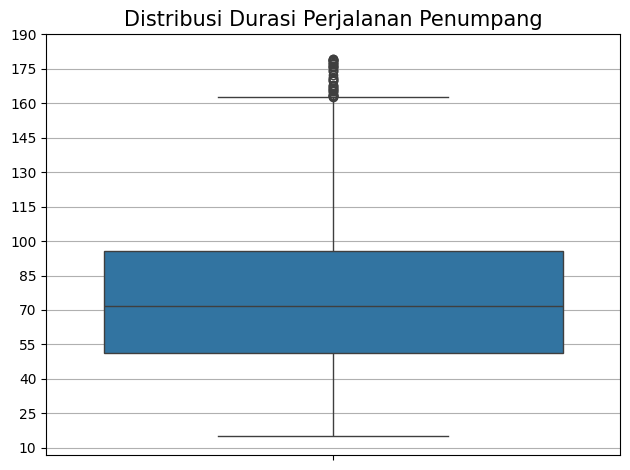

In [8]:
anomali_waktu = round((tj_raw['tapOutTime'] - tj_raw['tapInTime']).dt.total_seconds() / 60, 2)
sns.boxplot(anomali_waktu)
plt.yticks(range(10,195,15))
plt.grid(axis='y')
plt.title('Distribusi Durasi Perjalanan Penumpang', size=15)

plt.tight_layout();

Berdasarkan interval waktu perjalanan penumpang, terdapat `44 rows` yang memiliki anomali durasi perjalanan tidak wajar. Kita akan dokumentasikan terlebih dahulu dengan cara menyimpan `index` dari anomali ini. Kita investigasi serta tindak lanjuti pada tahapan *data cleansing* karena durasi perjalanan penumpang menjadi salah satu bagian penting dalam proses analisis yang akan kita lakukan nanti.

In [9]:
index_anomali_waktu = anomali_waktu[anomali_waktu > 160].index

display(
    len(anomali_waktu[index_anomali_waktu]),
    index_anomali_waktu
)

44

Index([37605, 37608, 37614, 37615, 37616, 37619, 37623, 37632, 37633, 37651,
       37661, 37663, 37665, 37672, 37674, 37681, 37692, 37702, 37710, 37719,
       37720, 37742, 37744, 37752, 37753, 37758, 37761, 37784, 37806, 37822,
       37824, 37831, 37837, 37851, 37859, 37861, 37867, 37871, 37874, 37875,
       37878, 37883, 37891, 37897],
      dtype='int64')

Selanjutnya mari kita cek untuk memastikan apakah terdapat duplikat data atau tidak pada dataset TransJakarta.

In [10]:
# tj_raw[tj_raw['payCardID'].duplicated()].head() # 4885331907664776, dki, Gandi Widodo, Sawo Kecik Raya, 2023-04-03 17:35:45, 2023-04-03 19:00:15

tj_raw[tj_raw['payCardID'].duplicated(keep=False)].head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0


In [11]:
display(
    tj_raw['transID'].duplicated().sum(), 
    tj_raw['payCardID'].duplicated().sum(), 
    tj_raw['payCardName'].duplicated().sum()
)

np.int64(0)

np.int64(35900)

np.int64(35907)

Dari sini kita dapat memahami bahwa dataset TransJakarta ini tidak terdapat duplikat, namun terdapat transaksi berulang dari *loyal customer* atau penumpang yang secara rutin memang menggunakan layanan Transjakarta untuk opsi transportasi utama mereka. Oleh karena itu, temuan ini akan kita biarkan karena *records* tersebut merupakan data yang valid.

In [12]:
pd.set_option('display.max_colwidth', 30)
unique_items = []

for col in tj_raw.columns :
    unique_items.append( [col, tj_raw[col].nunique(), tj_raw[col].unique()])

raw_desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=unique_items)
raw_desc

,Column Name,Number of Unique,Unique Sample
0,transID,37900,"[EIIW227B8L34VB, LGXO740D2..."
1,payCardID,2000,"[180062659848800, 48853319..."
2,payCardBank,6,"[emoney, dki, flazz, onlin..."
3,payCardName,1993,"[Bajragin Usada, Gandi Wid..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1..."
6,corridorID,221,"[5, 6C, R1A, 11D, 12, 1T, ..."
7,corridorName,216,"[Matraman Baru - Ancol, St..."
8,direction,2,"[1.0, 0.0]"
9,tapInStops,2570,"[P00142, B01963P, B00499P,..."


Dari hasil inspeksi yang telah kita lakukan, dapat disimpulkan bahwa:

- Dataset Transjakarta memiliki 37.900 baris & 22 kolom
- beberapa kolom, seperti: `corridorID`, `corridorName`, `tapInStops`, `tapOutStops`, `tapOutStopsName`, `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, `tapOutTime`, dan `payAmount` memiliki data kosong. Data kosong pada kolom-kolom tersebut diwakili dengan data `NaN`.
- Kolom `transID` memiliki 37900 nilai unik yang menunjukkan tidak terdapat transaksi duplikat pada dataset ini. Tetapi berdasarkan kolom `payCardID	` dan `payCardName`, terdapat catatan transaksi dari penumpang yang sama yang menggunakan layanan Transjakarta secara rutin.
- Kolom `payCardID`, `tapInStops`, dan `tapOutStops` berisikan ID unik untuk setiap kartu pembayaran, halde tap-in/tap-out penumpang, yang sudah terwakilkan keterangannya pada beberapa kolom lain. Oleh karena itu kolom `transID`, `tapInStops`, dan `tapOutStops` kurang relevan untuk analisis dan dapat kita _drop_ saja.
- Terdapat anomali di interval durasi perjalanan penumpang, mempertimbangkan untuk membuat kolom baru dari agregasi kolom `tapInTime` dan `tapOutTime` yang akan berisi durasi perjalanan dalam satuan menit agar dapat ditangani lebih lanjut.
- Beberapa kolom seperti: `tapOutStopsName, tapOutStopsLat, tapOutStopsLon, stopEndSeq, tapOutTime` mengandung jumlah `NaN` yang sama. Kita dapat asumsikan diawal bahwa setiap _missing value_ dari 5 kolom tersebut berada di _row_ yang sama. Kita akan cek dan pastikan lebih lanjut.
- Kolom `payCardBirthDate` dapat kita manfaatkan untuk mencari umur dari setiap penumpang (`2023 - payCardBirthDate`). Kita sesuaikan dimensi waktu karena dataset ini hanya berisikan *records* penumpang Transjakarta di bulan April tahun 2023.

### **Data Cleansing**

Kita *assign* dataset Transjakarta ke variabel baru, agar perubahan yang kita lakukan lebih leluasa dan efisien. Misalnya, jika sewaktu-waktu kita melakukan perubahan yang `berakibat fatal` ke proses analisis, kita dapat kembali ke bentuk dataset awal dengan mudah.

In [13]:
df_tj = tj_raw.copy()

##### **Missing Value Check**

In [14]:
df_missing = pd.DataFrame(df_tj.isna().sum()).rename(columns={0:'missingCount'})
df_missing['missingPercentage'] = round((df_missing['missingCount'] / len(df_tj)), 4) * 100
df_missing

,missingCount,missingPercentage
transID,0,0.00
payCardID,0,0.00
payCardBank,0,0.00
payCardName,0,0.00
payCardSex,0,0.00
payCardBirthDate,0,0.00
corridorID,1257,3.32
corridorName,1930,5.09
direction,0,0.00
tapInStops,1213,3.20


##### **Missing Value Distribution Check**

<Axes: >

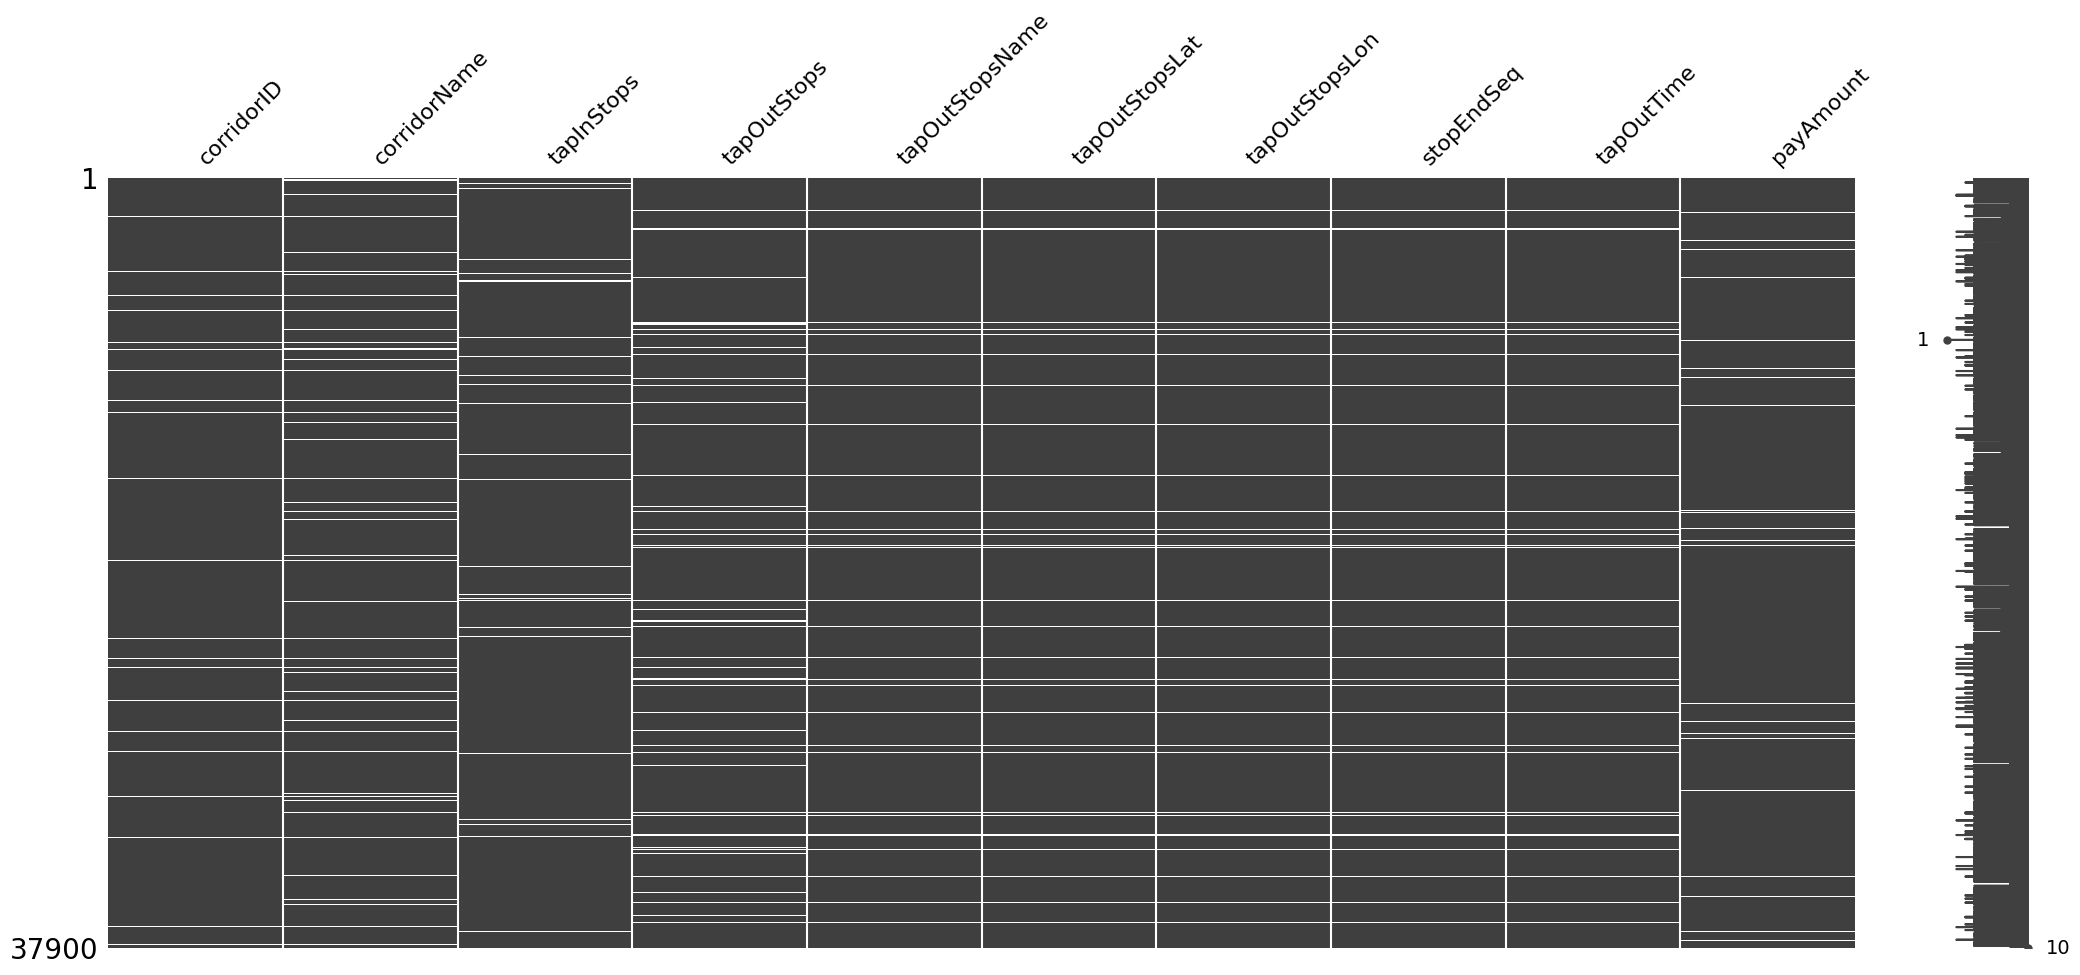

In [15]:
msno.matrix(df_tj[
                  ['corridorID', 'corridorName',
                  'tapInStops',
                  'tapOutStops', 'tapOutStopsName',
                  'tapOutStopsLat', 'tapOutStopsLon',
                  'stopEndSeq', 'tapOutTime',
                  'payAmount']
                  ]
            )

<Axes: >

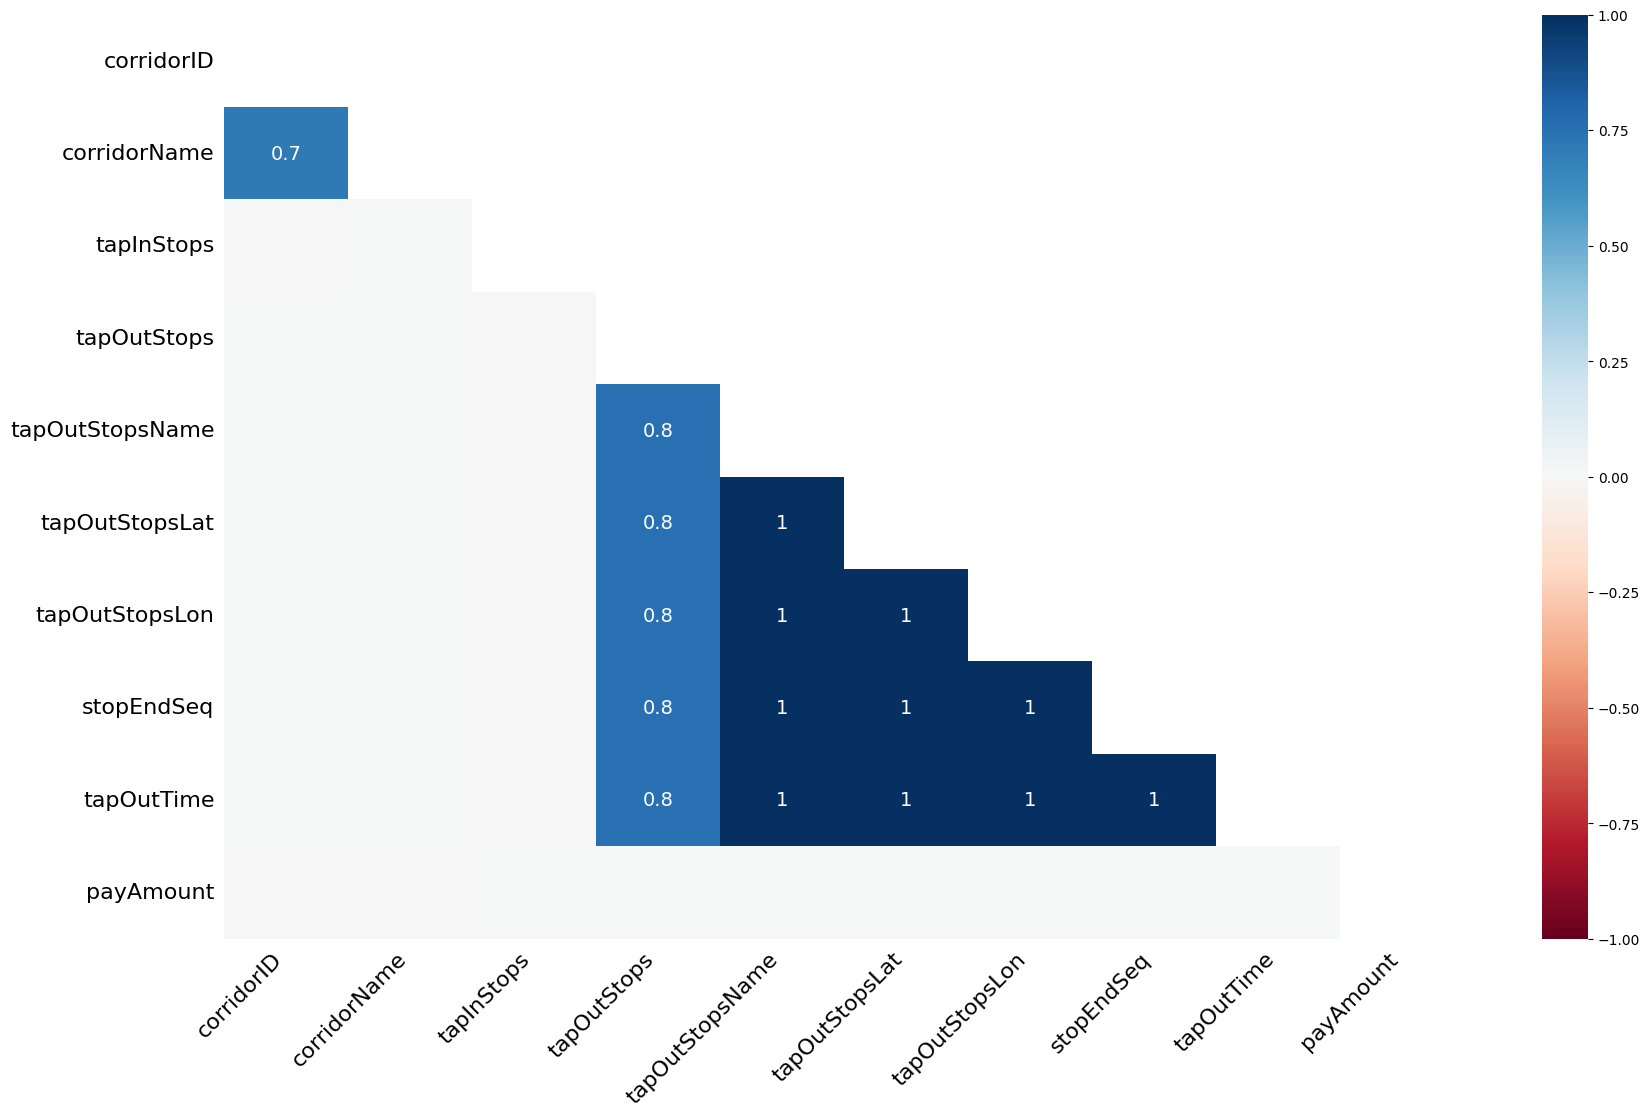

In [16]:
msno.heatmap(df_tj)

Secara garis besar:  
* Persentase *missing value* dari dataset Transjakarta hanya terdiri _kurang dari 10%_ dari setiap kolomnya. Dengan kolom `tapOutStops` yang memiliki _missing value_ terbanyak dengan persentase sebesar 6.04%
* *missing value* di kolom : `tapOutStopsName, tapOutStopsLat, tapOutStopsLon`, dan kolom `stopEndSeq` memiliki *missing values* yang saling berkaitan. Dengan kata lain, *missing value* dari berbagai kolom ini berada di row yang sama.

Ada beberapa cara untuk menangani *missing value*:

1. Jika persentase missing < 5% : `delete row`
1. 5-20% : `simple imputation` (mean, median, modus, constant)
1. 20-50% : `advanced immputer` (KKN, iterative imputer)
1. Jika persentase missing > 50% : `delete column`

* Kolom `corridorID`, `tapInStops`, dan `tapOutStops` dapat kita *drop*/biarkan saja karena bukan termasuk bagian yang dapat kita analisis (*column to drop*)
* Untuk `tapOutStopsName, tapOutStopsLat, tapOutStopsLon`, dan kolom `stopEndSeq`, tidak bisa langsung kita `dropna` karena *missing value* dari kolom-kolom tersebut saling berkaitan. Oleh karena itu, kita perlu melakukan imputasi untuk mengisi *missing value*.
* *Missing value* di kolom `payAmount` juga masih dapat kita isi dengan *domain knowledge* tarif Transjakarta yaitu dengan harga *flat* 3500 untuk setiap kali *tap in*. Dimana kita asumsikan, seharusnya *median* dan *mode* dari kolom `payAmount` juga merupakan 3500.

##### **Handle Missing Value**

Kita akan mulai mencoba imputasi ke kolom kategori yang terdapat *missing values* yaitu: `corridorName` dan `tapOutStopsName`. Mari kita mulai dari kolom `tapOutStopsName` karena kolom ini akan menjadi acuan saat kita imputasi kolom `corridorName` selanjutnya.

Untuk cara imputasi yang kita gunakan adalah mencoba mengisi *missing values* dengan menjadikan kolom lain sebagai acuan `SimpleImputer (most_frequent)`.

Imputasi akan dilakukan dengan data yang sudah ada, berdasarkan kolom-kolom yang saling berkorelasi, ataupun dengan *domain knowledge*. Tujuan imputasi ini agar persentase *missing values* pada dataset Transjakarta tidak ada yang melebihi 5%. Terakhir, dari sisa-sisa dari *missing values* nantinya dapat kita *drop*.

In [17]:
# df_tj.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
#     .transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)

In [18]:
mode_imputer = SimpleImputer(strategy='most_frequent')

df_tj['tapOutStopsName'] = df_tj.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
    .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

In [19]:
display(
    tj_raw['tapOutStopsName'].isna().sum(), 
    df_tj['tapOutStopsName'].isna().sum()
)

np.int64(1344)

np.int64(46)

Selanjutnya kita coba isi *missing values* di kolom `corridorName` dengan menjadikan kolom `tapinStopsName` dan `tapOutStopsName` sebagai acuannya.

In [20]:
df_tj['corridorName'] = df_tj.groupby(['direction','tapInStopsName','tapOutStopsName'])['corridorName'] \
    .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

In [21]:
display(
    tj_raw[['corridorName','tapOutStopsName']].isna().sum(), 
    df_tj[['corridorName','tapOutStopsName']].isna().sum()
)

corridorName       1930
tapOutStopsName    1344
dtype: int64

corridorName       174
tapOutStopsName     46
dtype: int64

Kita coba cek hasilnya apakah masuk akal atau tidak berdasarkan *domain knowledge* kita terhadap daerah dan ruas jalan di kota Jakarta.

In [22]:
display(
    tj_raw[(tj_raw['corridorName'].isna()) & (tj_raw['tapOutStopsName'].isna())][['corridorName','direction','tapInStopsName','tapOutStopsName']].head(),
    df_tj.iloc[[826,837,876,1395,2646]][['corridorName','direction','tapInStopsName','tapOutStopsName']]
    )

,corridorName,direction,tapInStopsName,tapOutStopsName
826,NaN,1.0,Stasiun Jatinegara Arah Utara,NaN
837,NaN,0.0,Ragunan,NaN
876,NaN,1.0,Jln. Prima,NaN
1395,NaN,1.0,Cut Meutia,NaN
2646,NaN,0.0,Tol Bekasi Timur 1,NaN


,corridorName,direction,tapInStopsName,tapOutStopsName
826,Tanjung Priok - PGC 2,1.0,Stasiun Jatinegara Arah Utara,Permai Koja Arah Utara
837,Ragunan - Gelora Bung Karno,0.0,Ragunan,Tendean
876,Rawa Buaya - Rawa Kompeni,1.0,Jln. Prima,Sbr. SMAN 95
1395,Gondangdia - Senen,1.0,Cut Meutia,Selatan St. Gondangdia
2646,Bekasi Timur - Cawang,0.0,Tol Bekasi Timur 1,BNN LRT


Selanjutnya kita akan coba `IterativeImputer` terhadap kolom numerik seperti `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, dan `tapOutTime` dengan mengacu kepada empat kolom saat penumpang melakukan *tap-in.*

**TapOutStopsLat & TapOutStopsLat**

In [23]:
col_to_validate = ['corridorName','direction','stopStartSeq','tapInTime','tapOutStopsLat','tapOutStopsLon','stopEndSeq','tapOutTime','payAmount']

In [24]:
# Define imputer
iter_imputer = IterativeImputer()

# Fit imputer
iter_imputer.fit(df_tj[['tapOutStopsLat','tapInStopsLat']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [25]:
# Transform
df_tj['tapOutStopsLat'] = iter_imputer.transform(df_tj[['tapOutStopsLat','tapInStopsLat']])
df_tj['tapOutStopsLat'] = df_tj['tapOutStopsLat'].astype('float64')

In [26]:
iter_imputer.fit(df_tj[['tapOutStopsLon','tapInStopsLon']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [27]:
df_tj['tapOutStopsLon'] = iter_imputer.transform(df_tj[['tapOutStopsLon','tapInStopsLon']])
df_tj['tapOutStopsLon'] = df_tj['tapOutStopsLon'].astype('float64')

**StopEndSeq**

In [28]:
iter_imputer.fit(df_tj[['stopEndSeq','stopStartSeq']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [29]:
df_tj['stopEndSeq'] = iter_imputer.transform(df_tj[['stopEndSeq','stopStartSeq']])
df_tj['stopEndSeq'] = df_tj['stopEndSeq'].astype('int64')

Mari kita cek hasilnya

In [30]:
display(
    tj_raw[tj_raw['stopEndSeq'].isna()][col_to_validate].head(),
    df_tj.iloc[[6,30,70,130,192]][col_to_validate]
    )

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaT,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,NaN,NaN,NaN,NaT,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,NaN,NaN,NaN,NaT,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,NaN,NaN,NaN,NaT,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,NaN,NaN,NaN,NaT,3500.0


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,-6.223368,106.850358,31,NaT,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,-6.291958,106.832726,26,NaT,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,-6.207782,106.823527,15,NaT,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,-6.169748,106.875205,15,NaT,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,-6.159427,106.747950,18,NaT,3500.0


**tapOutTime**

Kemudian kita akan isi *missing values* di kolom `tapOutTime` berdasarkan nilai rata-rata durasi perjalanan penumpang dari `tapInTime` + nilai `mean` atau `median`. 

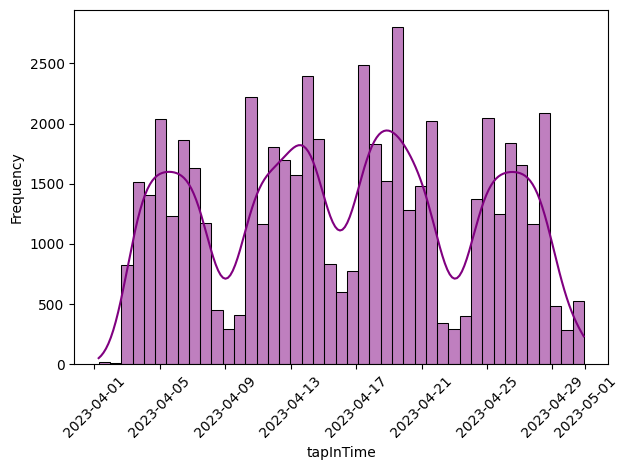

In [31]:
sns.histplot(df_tj['tapInTime'].astype('datetime64[ns]'), kde=True, stat='frequency', color='purple')
plt.xticks(rotation=45)
plt.tight_layout();

Setelah kita selesai *casting* tipe data di kolom `tapInTime` dan `tapOutTime` menjadi `datetime64[ns]`, sekarang kita coba cari `mean` dari durasi perjalanan penumpang Transjakarta.

In [32]:
display(
    round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().median() / 60, 2),
    round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().mean() / 60, 2)
)

np.float64(71.83)

np.float64(72.13)

Meskipun perbedaannya sangat kecil antara `mean` dan `median` dari durasi perjalanan penumpang Transjakarta, kita akan gunakan `median` agar lebih sesuai dengan bentuk persebaran datanya.

In [33]:
median_dur = round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().median() / 60, 2)

print(f'Rata-rata durasi perjalanan penumpang: {median_dur} menit')

Rata-rata durasi perjalanan penumpang: 71.83 menit


In [34]:
df_tj['tapOutTime'] = df_tj['tapOutTime'].fillna(df_tj['tapInTime'].apply(lambda x: x + pd.Timedelta(minutes=int(median_dur))))

**Mari cek hasilnya**

In [35]:
display(tj_raw[tj_raw['tapOutTime'].isna()][col_to_validate].head(), \
        df_tj.iloc[[6,30,70,130,192]][col_to_validate])

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaT,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,NaN,NaN,NaN,NaT,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,NaN,NaN,NaN,NaT,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,NaN,NaN,NaN,NaT,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,NaN,NaN,NaN,NaT,3500.0


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,-6.223368,106.850358,31,2023-04-03 08:09:21,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,-6.291958,106.832726,26,2023-04-03 07:25:02,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,-6.207782,106.823527,15,2023-04-03 07:08:55,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,-6.169748,106.875205,15,2023-04-03 06:51:04,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,-6.159427,106.747950,18,2023-04-03 07:26:53,3500.0


In [36]:
# Perbandingan dengan corridorID
display(
    tj_raw.groupby(['direction','tapInStopsName','tapOutStopsName'])['corridorName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 1473
    tj_raw.groupby(['corridorID','tapInStopsName','tapOutStopsName'])['corridorName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2605
)
# Perbandingan dengan tapInStops
display(
    tj_raw.groupby(['direction','tapOutStopsName'])['tapInStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 1344
    tj_raw.groupby(['tapInStops','tapOutStopsName'])['tapInStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2521
)
# Perbandingan dengan tapOutStops
display(
    tj_raw.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 46
    tj_raw.groupby(['tapOutStops','tapInStopsName'])['tapOutStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2289
)

np.int64(1473)

np.int64(2605)

np.int64(1344)

np.int64(2521)

np.int64(46)

np.int64(2289)

Tampaknya imputasi lebih efisien jika kita lakukan tanpa mengandalkan kolom `corridorID`, `tapInStops`, dan `tapOutStops`. Berarti ketiga kolom ini memang tidak relevan untuk analisa dan tidak dapat kita manfaatkan juga. Oleh karena itu mari kita *drop* ketiga kolom ini.

In [37]:
df_tj = df_tj.drop(columns=['corridorID','tapInStops','tapOutStops'], axis=1)
df_tj.columns

Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorName', 'direction', 'tapInStopsName',
       'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq', 'tapInTime',
       'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq',
       'tapOutTime', 'payAmount'],
      dtype='object')

Sekarang kita coba mengisi *missing values* di kolom `payAmount` yang bertipe numerik. Mari kita awali dengan melakukan *plot* agar dapat mengetahui bentuk distribusi datanya.

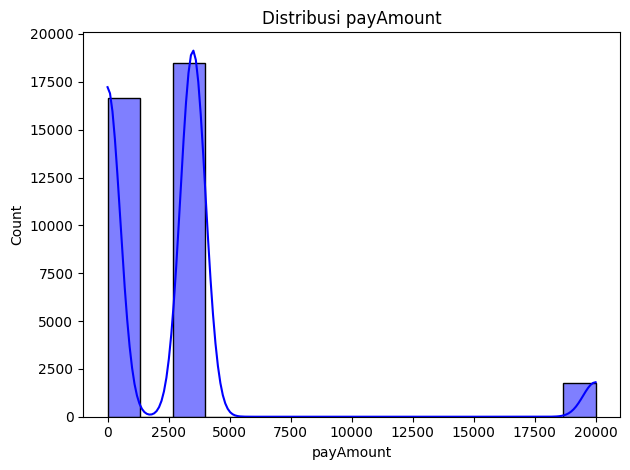

In [38]:
sns.histplot(df_tj['payAmount'], kde=True, bins=15, color='b')
plt.title('Distribusi payAmount')

plt.tight_layout();

Terlihat bahwa distribusi data pada kolom `payAmount` tidak berbentuk normal, melainkan terdiri dari beberapa nilai tetap yang berulang, yaitu Rp 0, Rp 3.500, dan Rp 20.000. Nilai Rp 3.500 merupakan tarif reguler Transjakarta, sedangkan Rp 0 kemungkinan berasal dari pengguna program subsidi (seperti ASN, lansia, atau Jaklingko).

Selain itu, terlihat bahwa terdapat anomali di kolom `payAmount` dengan nilai Rp 20.000, namun berdasarkan *domain knowledge*, Transjakarta memang menyediakan layanan bus premium dengan harga Rp 20.000 yang bernama [Royaltrans dan telah beroperasi sejak tahun 2017.](https://megapolitan.kompas.com/read/2023/08/27/01000061/tarif-royaltrans-dan-rutenya-2023)

Berdasarkan *domain knowledge* tersebut, kita ambil keputusan untuk **tidak merubah atau mengeliminasi** *outliers* di kolom `payAmount` karena kita justru bisa mendapatkan **insight** dengan cara menganalisa dan membandingkan 3 moda layanan Transjakarta untuk menjawab permasalahan yang telah kita rumuskan sebelumnya.

Selanjutnya, mita lanjutkan proses penanganan *missing values* untuk kolom `payAmount`.

In [39]:
df_tj[['payCardName','payCardBirthDate']].nunique()

payCardName         1993
payCardBirthDate      67
dtype: int64

Dengan distribusi yang tidak normal, kita kesampingkan imputasi berdasarkan `mean`, dan dengan kolom `payAmount` yang bertipe numerik, imputasi dengan `median` menjadi opsi yang lebih cocok untuk kita terapkan.

Kita akan lakukan `Simple Imputer` (`median`) berdasarkan kolom `payCardBirthDate` para penumpang Transjakarta. Karena terlihat dari 37900 *records*, tampaknya berasal dari `1993` orang yang memang mengandalkan layanan Transjakarta sebagai opsi utama transportasi mereka.

In [40]:
display(
    df_tj['payAmount'].isna().sum(),
    f'{round(df_tj['payAmount'].isna().sum() / len(df_tj) * 100, 2)}%'    
)

np.int64(1007)

'2.66%'

In [41]:
display(df_tj['payAmount'].mode(), df_tj['payAmount'].median())

0    3500.0
Name: payAmount, dtype: float64

np.float64(3500.0)

In [42]:
median_imputer = SimpleImputer(strategy='median')

In [43]:
display(
df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x).value_counts(),
df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x).isna().sum()
)

payAmount
3500.0     19294
0.0        16864
20000.0     1742
Name: count, dtype: int64

np.int64(0)

In [44]:
df_tj['payAmount'] = df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

**Sekarang kita bandingkan dan cek hasilnya**

In [45]:
tj_raw[tj_raw['payAmount'].isna()].sample(5).index

Index([11111, 6911, 21012, 23251, 26691], dtype='int64')

In [46]:
display( # 1669, 27329, 10876, 36708, 35887
    tj_raw.loc[[1669, 27329, 10876, 36708, 35887]][col_to_validate],
    df_tj.loc[[1669, 27329, 10876, 36708, 35887]][col_to_validate]
)

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
1669,BKN - Blok M,0.0,1,2023-04-05 17:59:10,-6.243369,106.80188,24.0,2023-04-05 19:34:26,NaN
27329,Tanjung Priok - Tanah Merdeka,1.0,10,2023-04-24 09:53:55,-6.127292,106.90605,11.0,2023-04-24 11:03:48,0.0
10876,Stasiun Tebet - Kampung Me...,0.0,1,2023-04-27 05:35:51,-6.220486,106.86825,11.0,2023-04-27 06:26:50,NaN
36708,BKN - Blok M,0.0,14,2023-04-17 18:13:35,-6.240036,106.82842,19.0,2023-04-17 19:18:09,NaN
35887,Stasiun Tebet - Rusun Kare...,0.0,10,2023-04-15 20:26:06,-6.221933,106.82093,12.0,2023-04-15 21:49:30,NaN


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
1669,BKN - Blok M,0.0,1,2023-04-05 17:59:10,-6.243369,106.80188,24,2023-04-05 19:34:26,3500.0
27329,Tanjung Priok - Tanah Merdeka,1.0,10,2023-04-24 09:53:55,-6.127292,106.90605,11,2023-04-24 11:03:48,0.0
10876,Stasiun Tebet - Kampung Me...,0.0,1,2023-04-27 05:35:51,-6.220486,106.86825,11,2023-04-27 06:26:50,3500.0
36708,BKN - Blok M,0.0,14,2023-04-17 18:13:35,-6.240036,106.82842,19,2023-04-17 19:18:09,3500.0
35887,Stasiun Tebet - Rusun Kare...,0.0,10,2023-04-15 20:26:06,-6.221933,106.82093,12,2023-04-15 21:49:30,0.0


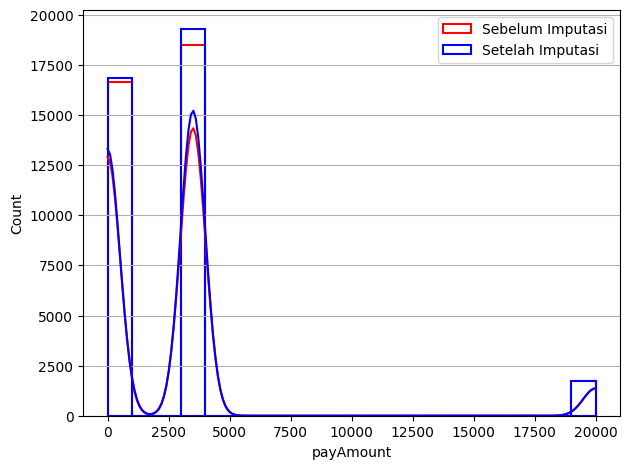

In [47]:
sns.histplot(tj_raw['payAmount'], kde=True, color='red', bins=20, fill=False, label='Sebelum Imputasi')
sns.histplot(df_tj['payAmount'], kde=True, color='blue', bins=20, fill=False, label='Setelah Imputasi')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()

Hasil imputasi pada kolom `payAmount` tidak mengakibatkan perubahan pada distribusi data, dan perbedaan yang ada juga masih bisa kita toleransi.

In [48]:
display(df_tj.columns, df_tj.isna().sum())

Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorName', 'direction', 'tapInStopsName',
       'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq', 'tapInTime',
       'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq',
       'tapOutTime', 'payAmount'],
      dtype='object')

transID               0
payCardID             0
payCardBank           0
payCardName           0
payCardSex            0
payCardBirthDate      0
corridorName        174
direction             0
tapInStopsName        0
tapInStopsLat         0
tapInStopsLon         0
stopStartSeq          0
tapInTime             0
tapOutStopsName      46
tapOutStopsLat        0
tapOutStopsLon        0
stopEndSeq            0
tapOutTime            0
payAmount             0
dtype: int64

In [49]:
df_tj.loc[:,df_tj.isna().sum() > 0].columns

Index(['corridorName', 'tapOutStopsName'], dtype='object')

In [50]:
df_tj_missing = pd.DataFrame(df_tj[['corridorName','tapOutStopsName']].isna().sum()).rename(columns={0:'missingCount'})
df_tj_missing['missingPercentage'] = round((df_tj_missing['missingCount'] / len(df_tj)), 4) * 100
df_tj_missing

,missingCount,missingPercentage
corridorName,174,0.46
tapOutStopsName,46,0.12


Setelah kita selsai mencoba `SimpleImputer` dan `IterativeImputer`, kini *missing values* dataset kita hanya memiliki *missing values* dengan persentase dibawah 1%. Oleh karena itu, kita bisa gunakan `dropna()` sebagai opsi terakhir.

#### **DF Cleaned**

Sekarang kita `drop` **Null** yang tersisa, dan mari kita bandingkan hasil total entries dataset kita sesudah dan sebelum kita melakukan cleansing.

In [51]:
df = df_tj.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37726 entries, 0 to 37899
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transID           37726 non-null  object        
 1   payCardID         37726 non-null  int64         
 2   payCardBank       37726 non-null  object        
 3   payCardName       37726 non-null  object        
 4   payCardSex        37726 non-null  object        
 5   payCardBirthDate  37726 non-null  int64         
 6   corridorName      37726 non-null  object        
 7   direction         37726 non-null  float64       
 8   tapInStopsName    37726 non-null  object        
 9   tapInStopsLat     37726 non-null  float64       
 10  tapInStopsLon     37726 non-null  float64       
 11  stopStartSeq      37726 non-null  int64         
 12  tapInTime         37726 non-null  datetime64[ns]
 13  tapOutStopsName   37726 non-null  object        
 14  tapOutStopsLat    37726 non

<Axes: >

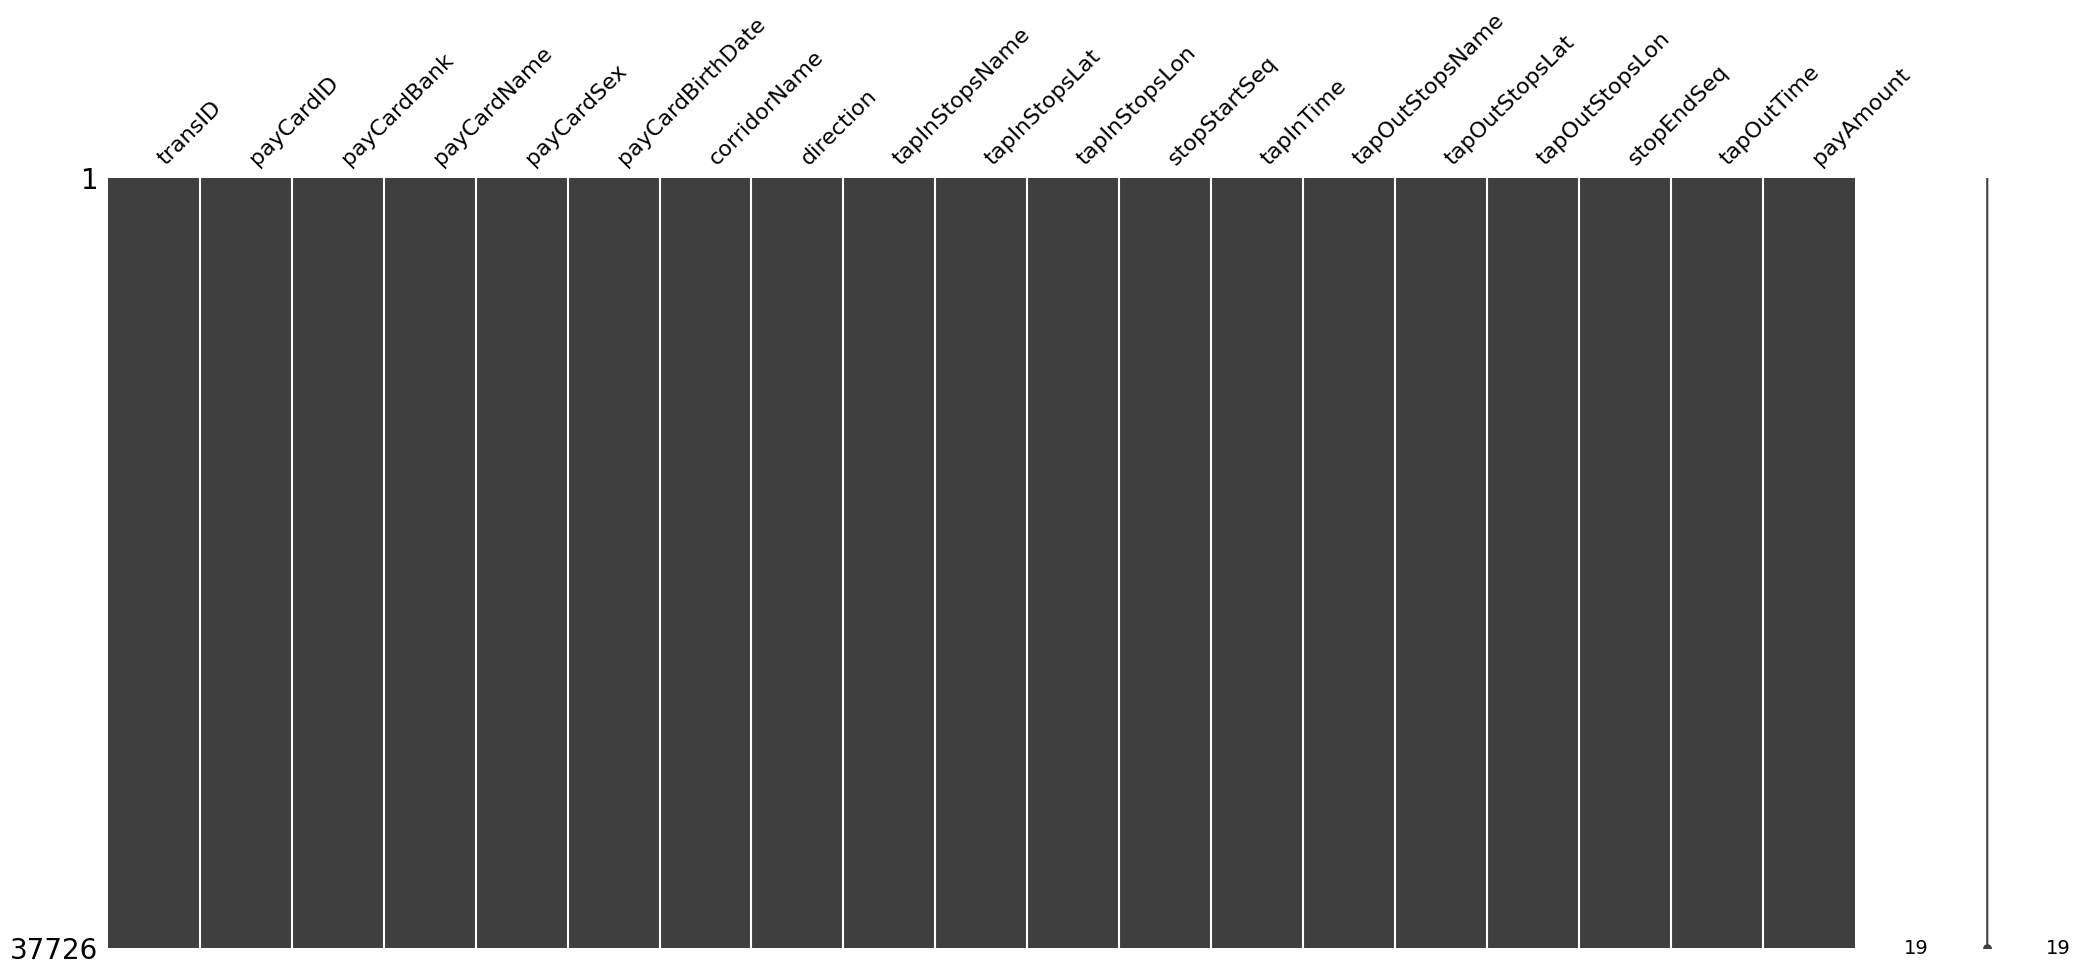

In [52]:
msno.matrix(df)

In [53]:
pd.set_option('display.max_colwidth', 60)
unique_items = []

for col in df.columns :
    unique_items.append( [col, df[col].nunique(), df[col].unique()])

raw_desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=unique_items)
raw_desc

,Column Name,Number of Unique,Unique Sample
0,transID,37726,"[EIIW227B8L34VB, LGXO740D2N47GZ, DJWR385V2U57TO, JTUZ800..."
1,payCardID,1982,"[180062659848800, 4885331907664776, 4996225095064169, 63..."
2,payCardBank,6,"[emoney, dki, flazz, online, brizzi, bni]"
3,payCardName,1975,"[Bajragin Usada, Gandi Widodo, Emong Wastuti, Surya Waca..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1982, 1993, 1974, 1991, 2004, 1..."
6,corridorName,216,"[Matraman Baru - Ancol, Stasiun Tebet - Karet via Patra ..."
7,direction,2,"[1.0, 0.0]"
8,tapInStopsName,2515,"[Pal Putih, Kemenkes 2, Gg. Kunir II, Taman Elok 1, Sunt..."
9,tapInStopsLat,2500,"[-6.184631, -6.2287, -6.133132, -6.195743, -6.14965, -6...."


In [54]:
df.isna().sum().sum()

np.int64(0)

Kita telah menyelesaikan proses *data cleansing* dan mari kita simpan hasil dataset yang sudah bersih menjadi file bernama `tj_cleaned.csv`

In [55]:
# df.to_csv('tj_cleaned.csv', index=False)

Kita telah pastikan tidak ada *record* yang duplikat dan terdapat *missing values*. Untuk proses analisis, kita juga tidak membutuhkan ID unik dari kolom `transID` dan `payCardID` karena tidak relevan, maka 2 kolom ini dapat kita `drop` saja.

In [56]:
df = df.iloc[:,2:]

In [57]:
df.sample(5)

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
29005,dki,R.M. Bakiadi Gunarto,M,1978,Bulak Turi - Tanjung Priok,0.0,Jln. Belimbing Terusan,-6.115462,106.92147,30,2023-04-26 08:59:00,Jln. Elpa Putih II,-6.110053,106.887210,50,2023-04-26 09:31:44,0.0
33051,emoney,Janet Hakim,M,2006,Cibubur - BKN,1.0,BKN,-6.257751,106.87000,0,2023-04-16 06:50:21,Cibubur Junction,-6.253995,106.866907,8,2023-04-16 08:01:21,3500.0
25860,flazz,Yahya Namaga,F,1994,Rusun Tambora - Pluit,1.0,Jembatan Dua,-6.143279,106.79352,3,2023-04-20 18:45:26,Rusun Tambora,-6.147327,106.798676,4,2023-04-20 19:40:02,0.0
22363,online,dr. Betania Saragih,F,1987,Jambore Cibubur - Pasar Rebo,1.0,Gereja Jemaat Kiwi,-6.339041,106.87215,15,2023-04-17 07:49:20,GOR Popki Cibubur,-6.367500,106.889230,37,2023-04-17 09:46:33,0.0
6774,online,Balapati Gunarto,M,1977,Rusun Tambora - Pluit,0.0,Jembatan Dua,-6.143279,106.79352,5,2023-04-18 06:06:36,Pluit,-6.115795,106.790370,8,2023-04-18 06:35:00,0.0


In [58]:
df.shape

(37726, 17)

In [59]:
print(f'Jumlah total entries sebelum proses cleansing = {len(tj_raw)}\n')
print(f'Jumlah total entries setelah proses cleansing = {len(df)}\n')
print(f'Persentase entries setelah proses cleansing = {round(len(df) / len(tj_raw) * 100, 2)}%')

Jumlah total entries sebelum proses cleansing = 37900

Jumlah total entries setelah proses cleansing = 37726

Persentase entries setelah proses cleansing = 99.54%


## **Data Analysis**

Akhirnya, kita sekarang dapat memulai proses analisis terhadap dataset TransJakarta yang sudah kita persiapkan.

Pertama, mari kita tindak lanjuti anomali seperti nilai `outlier` yang terdapat di dataset TransJakarta. Di bagian *data understanding* kita telah mengetahui terdapat anomali di kolom `payAmount` dan juga `durasi perjalanan penumpang`. 

Mempertimbangkan keputusan yang telah kita ambil berdasarkan *domain knowledge* terkait anomali di kolom `payAmount`, sekarang kita akan coba investigasi lebih lanjut untuk anomali di `durasi perjalanan`.

Sekarang kita buat kolom baru bernama `hours` dengan meng-ekstrak dari kolom `tapInTime` dan satu kolom baru lagi yaitu `travelTimeMnts` untuk mencari `durasi perjalanan` dari setiap penumpang dalam `satuan menit`.

In [60]:
df['travelTimeMnts'] = round((df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60, 2)
df['hours'] = df['tapInTime'].dt.hour

display(df['travelTimeMnts'].sample(2), df['hours'].sample(2), df.sample(3))

20087    114.25
20537     97.67
Name: travelTimeMnts, dtype: float64

27569    19
4457      6
Name: hours, dtype: int32

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours
29290,dki,"Simon Utama, S.Psi",F,1987,TU Gas - Bundaran Senayan,0.0,Sunan Giri,-6.193267,106.88367,4,2023-04-26 08:21:12,Karet Sudirman,-6.212457,106.82003,22,2023-04-26 10:18:12,3500.0,117.00,8
24749,bni,Legawa Oktaviani,F,1985,Bekasi Barat - Kuningan,0.0,Kuningan Madya 2,-6.213358,106.83027,13,2023-04-19 21:55:52,Menara Duta,-6.208617,106.82986,14,2023-04-19 23:26:36,20000.0,90.73,21
29966,flazz,"Gantar Namaga, S.Sos",F,1989,Pulo Gadung 2 - Tosari,0.0,Pasar Genjing,-6.194446,106.86092,11,2023-04-26 18:47:31,Matraman 2,-6.198910,106.85450,12,2023-04-26 19:42:01,3500.0,54.50,18


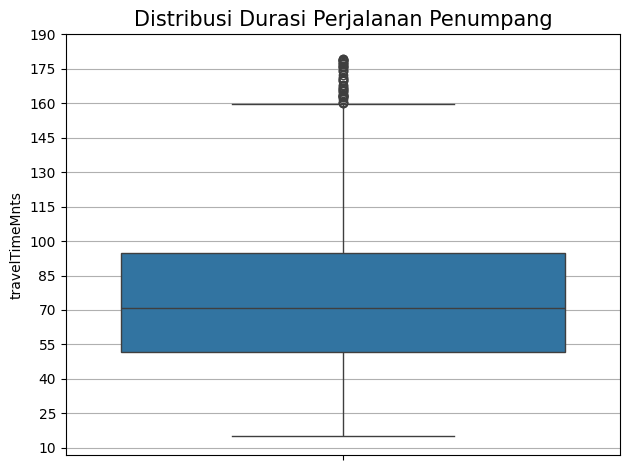

In [61]:
sns.boxplot(df['travelTimeMnts'])
plt.yticks(range(10,195,15))
plt.grid(axis='y')
plt.title('Distribusi Durasi Perjalanan Penumpang', size=15)

plt.tight_layout();

Kita coba definisikan `outlier` di kolom `travelTimeMnts` dengan mencari `IQR` dari kolom tersebut.

In [62]:
Q1 = df['travelTimeMnts'].quantile(0.25)
Q3 = df['travelTimeMnts'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['travelTimeMnts'] < lower_bound) | (df['travelTimeMnts'] > upper_bound)]

In [63]:
display(
    len(index_anomali_waktu),
    len(outliers),
    outliers.sample(3)
)

44

43

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours
37806,emoney,Tania Maulana,M,1983,Puri Beta 2 - Tendean,0.0,Kebayoran Lama,-6.238340,106.77752,7,2023-04-20 09:16:15,Mayestik,-6.241921,106.79077,8,2023-04-20 12:12:22,3500.0,176.12,9
37632,dki,Cut Ika Narpati,M,1975,Stasiun Manggarai - UI,1.0,H. Samali,-6.265888,106.84407,23,2023-04-13 13:58:10,Masjid Jami Baiturrahman,-6.216586,106.84412,43,2023-04-13 16:44:29,3500.0,166.32,13
37619,flazz,"Lanang Firmansyah, M.Farm",F,1983,Ragunan - MH Thamrin via Kuningan,1.0,Kuningan Timur,-6.234731,106.82902,8,2023-04-12 13:26:00,Pejaten,-6.278404,106.82972,14,2023-04-12 16:22:23,3500.0,176.38,13


Berdasarkan `IQR`, ditemukan `43 outlier` perjalanan dengan durasi di atas `160 menit`. *Records* ini kita `drop` saja dari dataset karena dianggap tidak merepresentasikan durasi perjalanan wajar TransJakarta dan berpotensi disebabkan oleh kesalahan pencatatan sistem.

In [64]:
df = df.drop(index = outliers.index)
df.shape

(37683, 19)

Mari kita tambahkan kolom baru yaitu `age` agar dapat melihat demografi penumpang TransJakarta tidak hanya berdasarkan `gender` tapi juga bisa kita lihat berdasarkan `usia`.

In [65]:
df['age'] = (2023 - df['payCardBirthDate']).astype(int)

### **Berdasarkan Arah Tujuan Penumpang TransJakarta**

1. Bagaimana distribusi data durasi perjalanan penumpang TransJakarta?
1. Apakah terdapat perbedaan rata-rata durasi perjalanan untuk arah `berangkat` dan `kembali`?

Mari kita uji normalitas kolom `travelTimeMnts`.

In [66]:
from scipy.stats import kstest

stats, pval = kstest(df['travelTimeMnts'], 'norm')
if pval <= 0.05:
    print('Distribusi tidak normal') #Ha
else:
    print('Distribusi Normal') #Ho

Distribusi tidak normal


Kita akan melakukan uji banding rata-rata non-parametrik karena distribusi datanya tidak normal. Oleh karena itu, kita gunakan `Mann Whitney` untuk membandingkan arah pergi dan pulang. 

In [67]:
from scipy.stats import mannwhitneyu

h0 = 'Tidak terdapat perbedaan rata-rata durasi perjalanan antara penumpang yang arah pergi dengan yang arah pulang/kembali.'
ha = 'Terdapat perbedaan rata-rata durasi perjalanan yang signifikan antara penumpang yang arah pergi dengan yang arah pulang/kembali.'

corr, pval = mannwhitneyu(df['travelTimeMnts'], df['direction'])
print(f'Korelasi: {corr}, p-value: {pval}')

if pval <= 0.05:
    print('Tolak H0') #Ha
    print(ha)
else:
    print('Gagal menolak H0') #Ho
    print(h0)

Korelasi: 1420008489.0, p-value: 0.0
Tolak H0
Terdapat perbedaan rata-rata durasi perjalanan yang signifikan antara penumpang yang arah pergi dengan yang arah pulang/kembali.


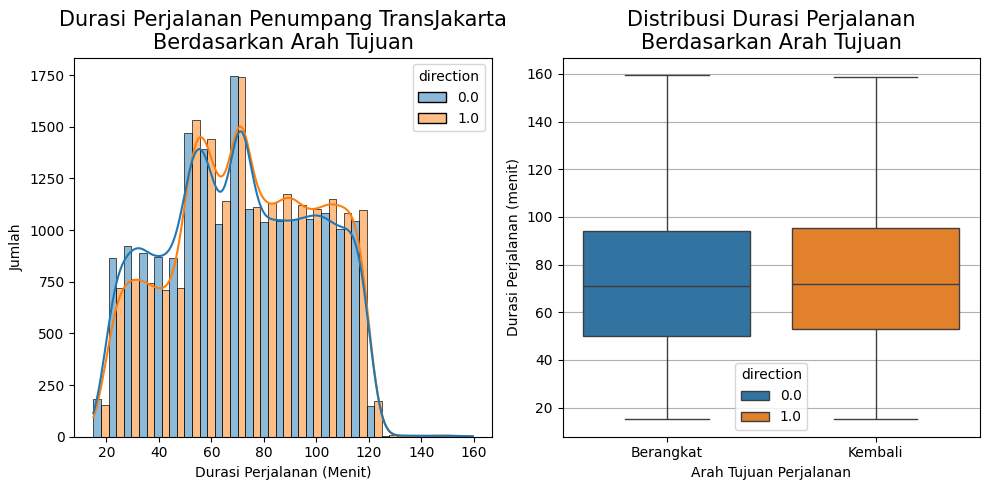

In [68]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.histplot(df, x='travelTimeMnts', kde=True, hue='direction', bins=25, multiple='dodge', ax=ax[0])
ax[0].set_title('Durasi Perjalanan Penumpang TransJakarta\nBerdasarkan Arah Tujuan', size=15)
ax[0].set_xlabel('Durasi Perjalanan (Menit)')
ax[0].set_ylabel('Jumlah')

sns.boxplot(data=df, x='direction', y='travelTimeMnts', hue='direction', ax=ax[1])
ax[1].set_xticks([0, 1], ['Berangkat','Kembali'])
ax[1].set_title('Distribusi Durasi Perjalanan\nBerdasarkan Arah Tujuan', size=15)
ax[1].set_ylabel('Durasi Perjalanan (menit)')
ax[1].set_xlabel('Arah Tujuan Perjalanan')
ax[1].grid(axis='y')

plt.tight_layout();

**Rata-rata Durasi Perjalanan Berdasarkan Rute TransJakarta**

1. Berapa nilai `mean` dan `median` dari durasi perjalanan TransJakarta?

In [69]:
print(f'Berikut adalah rangkuman statistik untuk kolom travelTimeMnts:')
df['travelTimeMnts'].agg(['mean','median','min','max'])

Berikut adalah rangkuman statistik untuk kolom travelTimeMnts:


mean       71.967046
median     71.000000
min        15.000000
max       159.630000
Name: travelTimeMnts, dtype: float64

### `Checkpoint`

1. Perbedaan durasi perjalanan antar arah perjalanan (direction).

1. Apakah rute memengaruhi durasi perjalanan.

1. Perbedaan tarif dengan durasi.

1. Perbedaan durasi berdasarkan demografi (jenis kelamin, usia).

1. Durasi perjalanan berdasarkan waktu (jam/tanggal).

    * Visualisasi durasi antar tiap kategori
    * Korelasi kolom numerik -> heatmap

* Mana yang paling mempengaruhi durasi perjalanan?
* Perbedaan yang paling jauh ada di faktor mana?


In [70]:
rute_terlama = pd.DataFrame(df.groupby('corridorName')['travelTimeMnts'] \
               .mean().sort_values(ascending=False).head(10)).reset_index()
rute_terlama

,corridorName,travelTimeMnts
0,Kampung Rambutan - Blok M,84.985294
1,Cinere - Kuningan,81.472614
2,Stasiun Palmerah - Tosari,81.250872
3,Senen - Pulo Gadung via Kelapa Gading,79.859307
4,Rawamangun - Klender,79.730408
5,Pinang Ranti - Bundaran Senayan,79.539267
6,Tanah Abang - Kebayoran Lama via Pos Pengumben,79.314583
7,Puri Kembangan - Sentraland Cengkareng,78.678523
8,Grogol - Pos Pengumben via Slipi,78.645476
9,Term. Pulo Gadung - Lampiri,78.501290


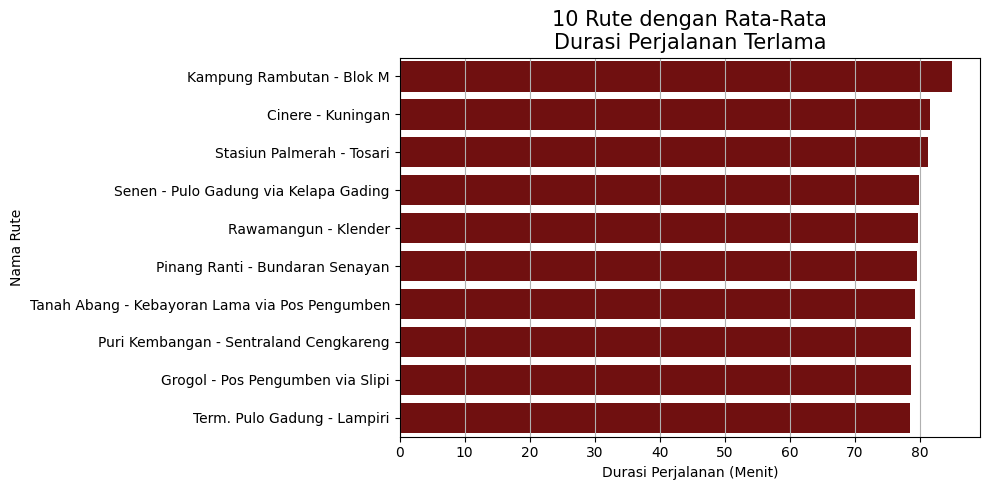

In [71]:
plt.figure(figsize=(10,5))
sns.barplot(rute_terlama, y='corridorName', x='travelTimeMnts', color='maroon')
plt.title('10 Rute dengan Rata-Rata\nDurasi Perjalanan Terlama', size=15)
plt.xlabel('Durasi Perjalanan (Menit)')
plt.ylabel('Nama Rute')
plt.grid(axis='x')

plt.tight_layout();

Sebuah temuan yang menarik karena 3 peringkat teratas dari rute dengan rata-rata durasi perjalanan tertinggi semuanya berada di ruas jalan area `Jakarta Selatan`. Masuk akal karena memang area Jakarta Selatan menjadi area tersibuk karena didominasi oleh aktivitas bisnis dan perkantoran.

###  **Rata-rata Durasi Perjalanan Tertinggi Berdasarkan Tarif**

In [72]:
tarif = pd.DataFrame(round(df.groupby('payAmount')['travelTimeMnts'].mean(), 2).reset_index())
tarif

,payAmount,travelTimeMnts
0,0.0,72.26
1,3500.0,71.53
2,20000.0,73.98


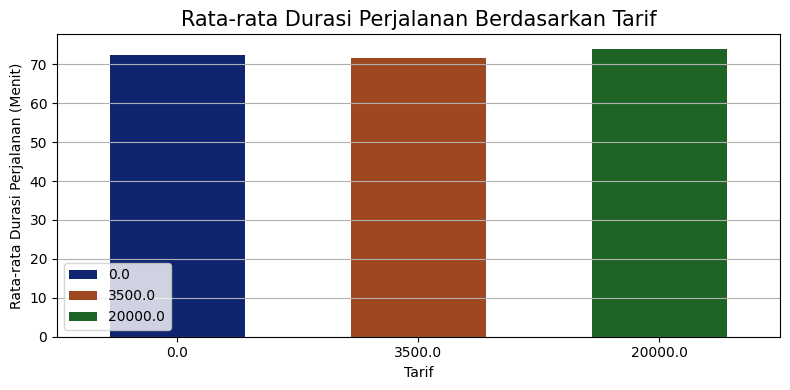

In [73]:
plt.figure(figsize=(8,4))
sns.barplot(data=tarif, x='payAmount', y='travelTimeMnts', hue='payAmount', palette='dark', legend='full', width=0.56)
plt.title('Rata-rata Durasi Perjalanan Berdasarkan Tarif', size=15)
plt.xlabel('Tarif')
plt.ylabel('Rata-rata Durasi Perjalanan (Menit)')
plt.legend(loc='lower left')
plt.grid(axis='y')

plt.tight_layout();

In [74]:
pause

NameError: name 'pause' is not defined

<Axes: xlabel='hours', ylabel='travelTimeMnts'>

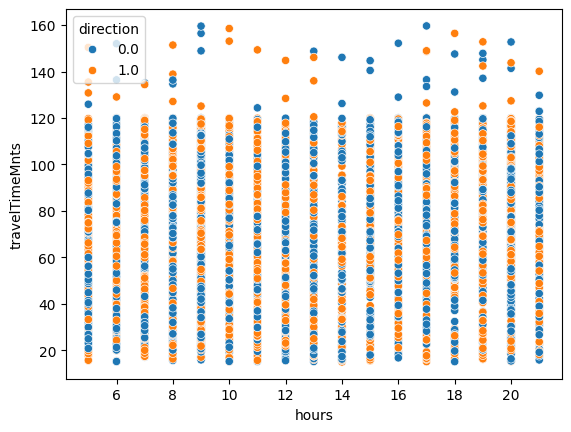

In [ ]:
sns.scatterplot(df, y='travelTimeMnts', x='hours', hue='direction')

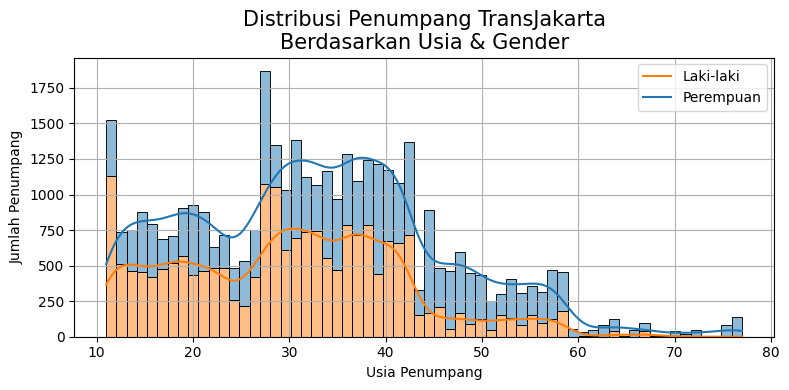

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df[['payCardSex','age']], x='age', hue='payCardSex', kde=True, multiple='stack', legend=True)
plt.xlabel('Usia Penumpang')
plt.ylabel('Jumlah Penumpang')
plt.title('Distribusi Penumpang TransJakarta\nBerdasarkan Usia & Gender', size=15)
plt.legend(['Laki-laki','Perempuan'])
plt.grid()

plt.tight_layout();

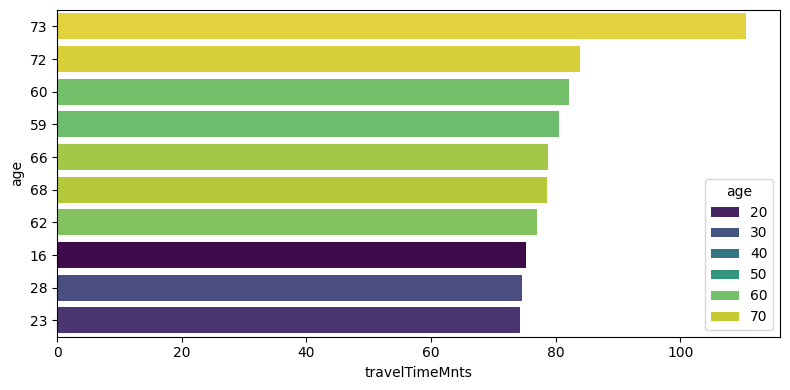

In [ ]:
faktor_usia = pd.DataFrame(df.groupby('age')['travelTimeMnts'].mean().sort_values(ascending=False).head(10)).reset_index()

plt.figure(figsize=(8,4))
sns.barplot(faktor_usia, y='age', x='travelTimeMnts', orient='h', palette='viridis', hue='age', order=faktor_usia['age'])

plt.tight_layout();

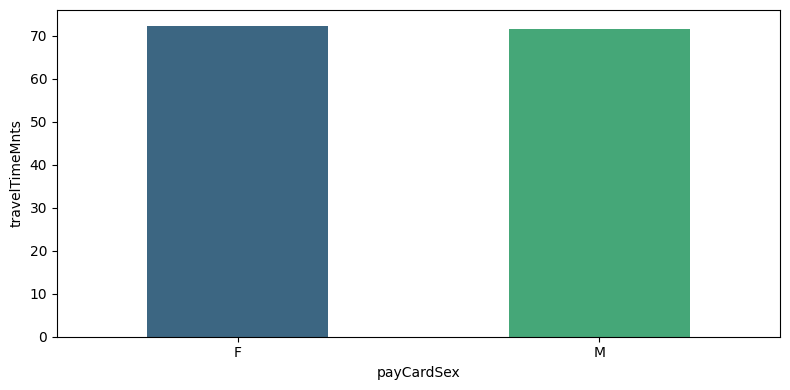

In [ ]:
faktor_gender = pd.DataFrame(df.groupby('payCardSex')['travelTimeMnts'].mean().sort_values(ascending=False).head(10)).reset_index()

plt.figure(figsize=(8,4))
sns.barplot(faktor_gender, x='payCardSex', y='travelTimeMnts', palette='viridis', hue='payCardSex', \
            order=faktor_gender['payCardSex'], width=0.5)

plt.tight_layout();

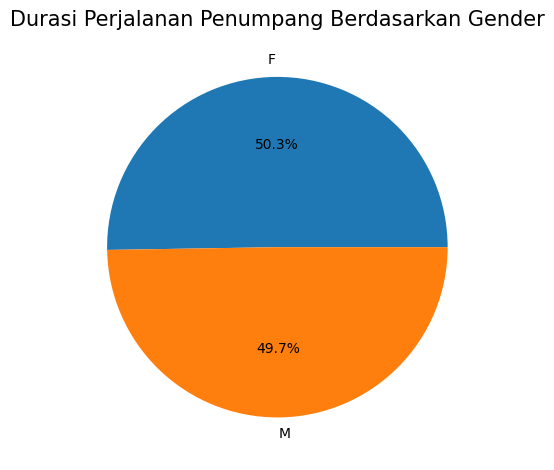

In [ ]:
df.groupby('payCardSex')['travelTimeMnts'].mean() \
.plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title('Durasi Perjalanan Penumpang Berdasarkan Gender', size=15)

plt.tight_layout();

### **Durasi Perjalanan Berdasarkan Rute**

1. Berapa lama rata-rata waktu perjalanan di setiap rute?
1. Apa 10 rute dengan durasi perjalanan tertinggi?
1. Apa 10 rute dengan penumpang terpadat?

In [ ]:
rute_terlama = pd.DataFrame(df.groupby('corridorName')['travelTimeMnts'] \
               .mean().sort_values(ascending=False).head(10)).reset_index()
rute_terlama

plt.figure(figsize=(8,4))
sns.barplot(rute_terlama, y='corridorName', x='travelTimeMnts', palette='rocket')
plt.title('10 Rute dengan Rata-Rata\nDurasi Perjalanan Terlama', size=15)
plt.xlabel('Durasi Perjalanan (Menit)')
plt.ylabel('Nama Rute')
plt.grid(axis='x')

plt.tight_layout();

,corridorName,travelTimeMnts
0,Kampung Rambutan - Blok M,84.985294
1,Cinere - Kuningan,81.472614
2,Stasiun Palmerah - Tosari,81.250872
3,Senen - Pulo Gadung via Kelapa Gading,79.859307
4,Rawamangun - Klender,79.730408
5,Pinang Ranti - Bundaran Senayan,79.539267
6,Tanah Abang - Kebayoran Lama via Pos Pengumben,79.314583
7,Puri Kembangan - Sentraland Cengkareng,78.678523
8,Grogol - Pos Pengumben via Slipi,78.645476
9,Term. Pulo Gadung - Lampiri,78.501290


Tampaknya 3 peringkat teratas dari rute dengan rata-rata durasi perjalanan paling lama semuanya berada di ruas jalan area `Jakarta Selatan`. Mari kita visualisasikan dengan `bar chart` karena kita ingin melihat perbandingan rata-rata durasi perjalanan dari setiap rutenya.

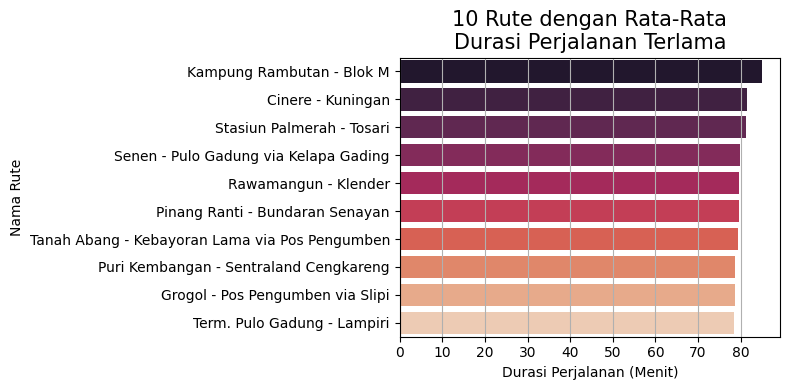

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(rute_terlama, y='corridorName', x='travelTimeMnts', palette='rocket')
plt.title('10 Rute dengan Rata-Rata\nDurasi Perjalanan Terlama', size=15)
plt.xlabel('Durasi Perjalanan (Menit)')
plt.ylabel('Nama Rute')
plt.grid(axis='x')

plt.tight_layout();

Mengacu kepada [Google Maps direction](https://maps.app.goo.gl/W4R4qDaF7wd2Xqyv6), durasi perjalanan yang dibutuhkan untuk rute `Kampung Rambutan - Blok M yaitu sekitar 35-45 menit untuk kendaraan roda 2 maupun roda 4`. Perbedaan durasi perjalanan antara menggunakan kendaraan pribadi dengan layanan Transjakarta, memang menjadi sebuah pertimbangan yang membuat masih banyak masyarakat yang lebih memilih untuk tetap menggunakan kendaraan pribadi untuk pilihan transportasi mereka sehari-hari.

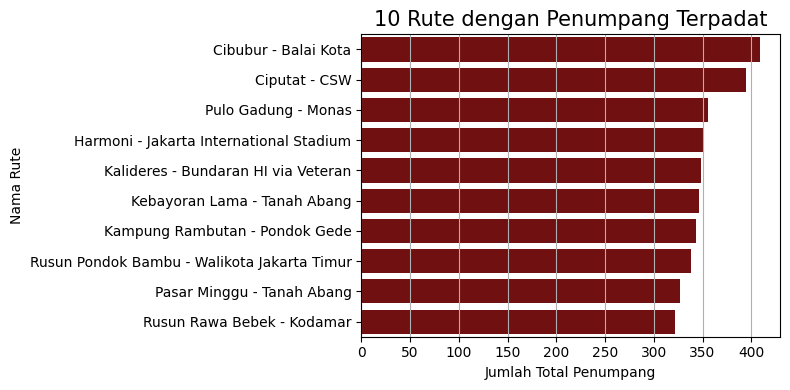

In [ ]:
rute_terpadat = df['corridorName'].value_counts().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(rute_terpadat, orient='h', color='maroon')
plt.title('10 Rute dengan Penumpang Terpadat', size=15)
plt.xlabel('Jumlah Total Penumpang')
plt.ylabel('Nama Rute')
plt.grid(axis='x')

plt.tight_layout();

### **Durasi Perjalanan Berdasarkan Jam-Jam Tertentu *(Rush Hour)***

Mari kita coba lihat apakah terdapat jam atau periode waktu tertentu setiap harinya, yang mempengaruhi panjangnya durasi perjalanan Transjakarta.

In [ ]:
rush_hour = pd.crosstab(df['travelTimeMnts'],df['hours'])
rush_hour['Total'] = rush_hour.sum(axis=1)
rush_hour = rush_hour.sort_values('Total',ascending=False).head(10)
rush_hour

hours,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,Total
travelTimeMnts,,,,,,,,,,,,,,,,,,
71.00,115,213,111,93,88,8,5,5,5,7,12,118,200,93,86,76,65,1300
54.02,2,3,1,0,0,0,0,1,0,0,0,2,3,1,2,3,0,18
76.75,1,3,1,1,1,0,0,0,0,0,1,5,1,0,1,2,1,18
54.82,1,4,0,0,2,0,0,0,0,0,0,2,3,1,2,1,1,17
59.75,3,2,3,1,0,1,0,0,1,0,0,1,3,0,2,0,0,17
56.20,5,3,2,2,0,0,0,0,1,0,0,0,4,0,0,0,0,17
52.05,1,3,0,4,0,0,0,0,0,0,0,0,4,1,0,2,2,17
57.72,5,4,0,0,0,0,1,0,0,0,0,0,4,0,1,0,2,17
55.23,0,2,1,1,0,0,0,0,0,0,0,2,4,0,3,2,1,16


Tampaknya durasi perjalanan tertinggi `(71 menit)` terjadi di jam-jam tertentu saja (*rush hour*), mari kita coba visualisasikan dengan `line chart` agar dapat melihat durasi perjalanan Transjakarta.

In [ ]:
top_10_rush_hour = pd.DataFrame(df.groupby('hours')['travelTimeMnts'].mean().sort_values())
top_10_rush_hour.tail(10)

,travelTimeMnts
hours,
13,69.839142
9,70.242632
8,70.797814
15,79.325128
19,82.978795
21,83.121864
18,83.280144
17,83.375155
20,83.380225


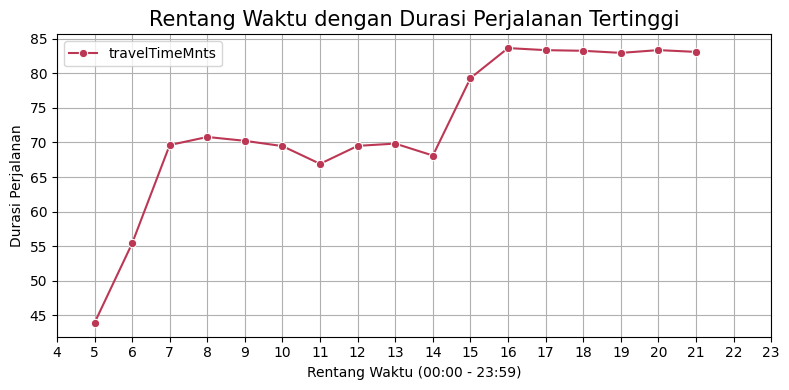

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(top_10_rush_hour, markers='o', palette='inferno')
plt.xticks(range(4,24))
plt.xlabel('Rentang Waktu (00:00 - 23:59)')
plt.ylabel('Durasi Perjalanan')
plt.title('Rentang Waktu dengan Durasi Perjalanan Tertinggi', size=15)
plt.grid()

plt.tight_layout();

Lonjakan pertama terjadi mulai dari jam `setengah 7 pagi`, masuk akal karena pada rentang waktu ini masyarakat mulai beraktivitas seperti pergi kerja, kemudian mencapai *peak rush hour* mulai dari `jam 4 sore sampai 9 malam` dengan rata-rata durasi perjalanan `paling tinggi` di angka `82-83 menit.`

In [ ]:
df.groupby('corridorName')['travelTimeMnts'].max().sort_values(ascending=False).head(10)

corridorName
Rusun Marunda - Tanjung Priok                     159.63
Puri Beta - Pancoran Barat                        159.55
Terminal Tanjung Priok - Ancol Barat              158.52
Kampung Rambutan - Blok M                         156.42
Pulo Gadung - Kota                                156.42
Kampung Rambutan - Pinang Ranti                   153.08
Cinere - Kuningan                                 152.72
Pasar Minggu - Ciganjur via KB Ragunan            152.18
Bintaro - Blok M                                  151.97
Tanah Abang - Kebayoran Lama via Pos Pengumben    149.32
Name: travelTimeMnts, dtype: float64

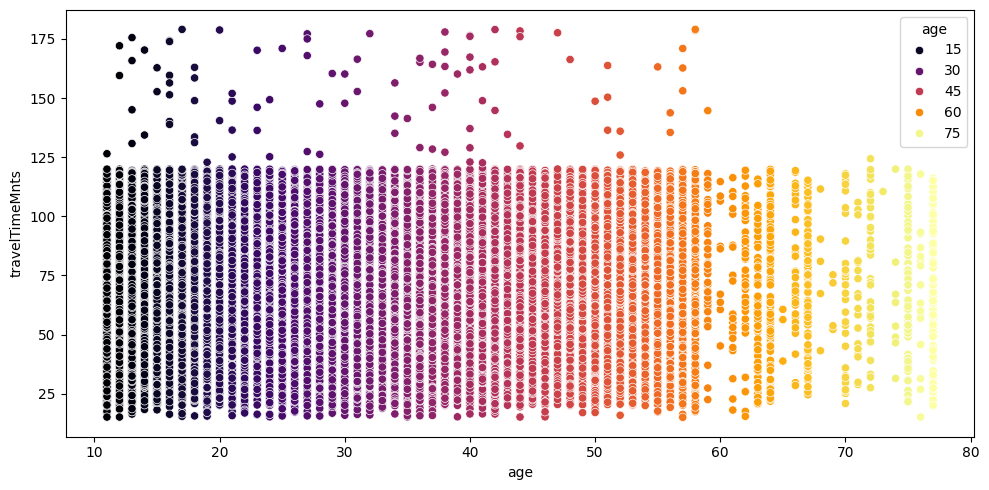

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(df[['age','travelTimeMnts']], y='travelTimeMnts', x='age', hue='age', palette='inferno')

plt.tight_layout();

In [ ]:
df['travelTimeMnts'].describe()

count    37726.000000
mean        72.078906
std         27.570161
min         15.000000
25%         51.722500
50%         71.000000
75%         94.900000
max        179.050000
Name: travelTimeMnts, dtype: float64

In [ ]:
df['payCardSex'].value_counts()

payCardSex
F    20066
M    17660
Name: count, dtype: int64

In [ ]:
display(
    df[(df['tapInTime'].dt.hour == 5) & (df['tapInTime'].dt.minute < 1)][:1],
    df[df['tapOutTime'].dt.hour < 4],
    df[df['tapInTime'].dt.hour == 21][-2:-1]
)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
149,OVAQ760H7C61IE,4946777822784,online,Wirda Yuliarti,M,1990,Matraman Baru - Ancol,0.0,Slamet Riyadi,-6.208533,106.85929,1,2023-04-03 05:00:14,Budi Utomo,-6.166063,106.83906,9,2023-04-03 05:33:29,3500.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37615,JEES739W6T40LL,3563362178943707,dki,drg. Michelle Puspita,F,1968,Rusun Rawa Bebek - Kodamar,0.0,Gg. Sawo 1,-6.20176,106.93513,11,2023-04-24 21:46:56,Kayu Mas,-6.17911,106.90255,25,2023-04-25 00:30:08,0.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37896,YHHK837P6Y95GN,6502902290603767,dki,Titi Siregar,M,1974,Pinang Ranti - Pramuka,1.0,Garuda Taman Mini,-6.290154,106.88116,1,2023-04-18 21:52:31,Pinang Ranti,-6.291075,106.88634,2,2023-04-18 22:28:22,3500.0


`Menarik. Bahkan ada 1 penumpang yang baru tiba di tujuan di atas jam 12 malam, dengan waktu perjalanan 2 jam lebih.`

p.s itu dokter Michelle mau berangkat kemanasi berangkat malem-malem...

In [ ]:
df.sample()

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,hours,travelTimeMnts,age
5464,dki,Gangsa Widodo,M,1966,Rusun Pesakih - Kalideres,1.0,Pertamina Kalideres Daan Mogot,-6.15571,106.70927,2,2023-04-14 05:32:53,Rusun Pesakih,-6.161468,106.71698,4,2023-04-14 06:19:15,0.0,5,46.37,57


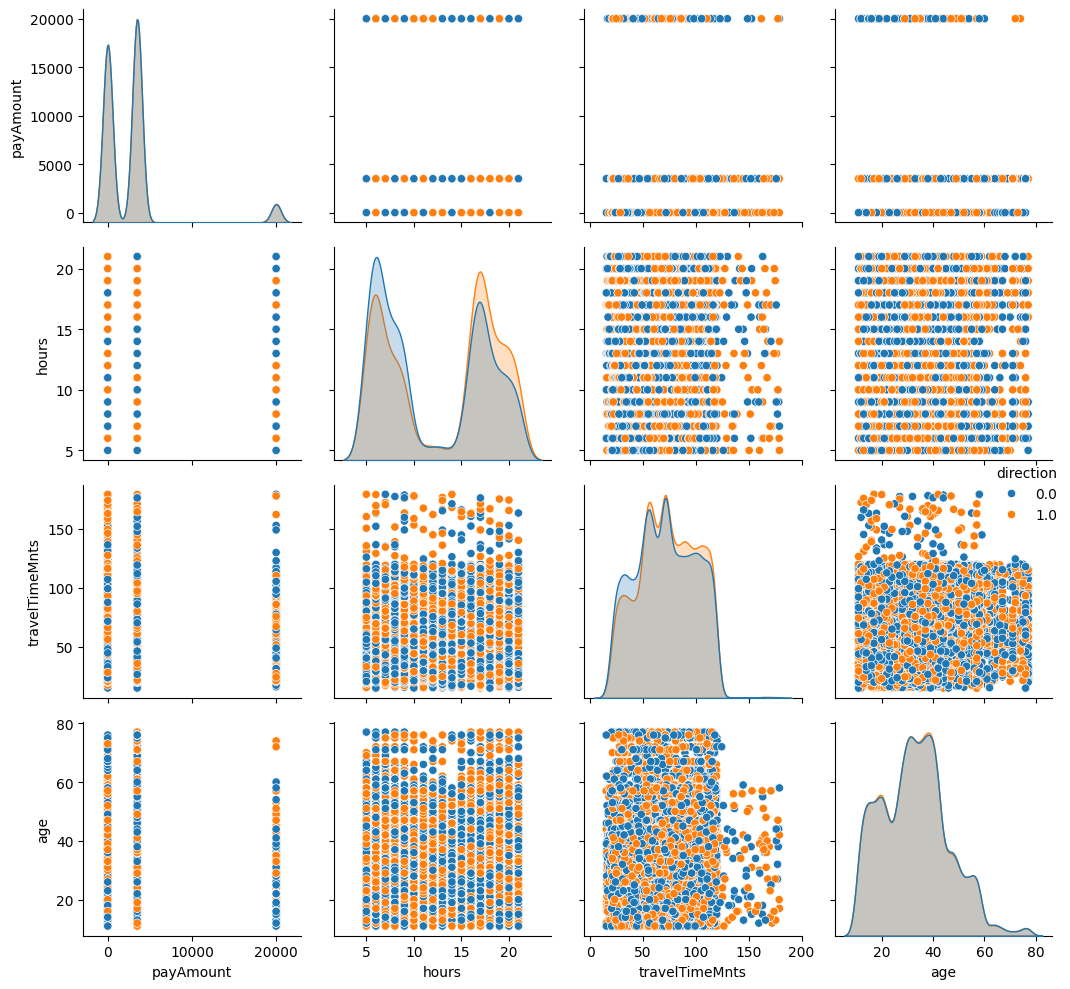

In [ ]:
sns.pairplot(df[[
   # 'payCardBank', 'payCardName', 'payCardSex', 'payCardBirthDate', 'corridorName', 
   'direction', 
   # 'tapInStopsName', 'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq',
      #  'tapInTime', 'tapOutStopsName',
      #  'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq', 
      #  'tapOutTime',
       'payAmount', 'hours', 'travelTimeMnts', 'age'
       ]], hue='direction')

plt.tight_layout();